# Kernel-based Time-varying Regression - Part II

The previous tutorial covered the basic syntax and structure of **KTR** (or so called **BTVC**); time-series data was fitted with a KTR model accounting for trend and seasonality.  In this tutorial a KTR model is fit with trend, seasonality, and additional regressors. To summarize part 1, **KTR** considers a time-series as an additive combination of local-trend, seasonality, and additional regressors. The coefficients for all three components are allowed to vary over time.  The time-varying of the coefficients is modeled using kernel smoothing of latent variables. This can also be an advantage of picking this model over other static regression coefficients models. 

This tutorial covers:

1. KTR model structure with regression
2. syntax to initialize, fit and predict a model with regressors
3. visualization of regression coefficients


In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style
from orbit.constants.palette import OrbitPalette

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.use(orbit_style);

/Users/towinazure/opt/miniconda3/envs/jupyter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(orbit.__version__)

1.1.3dev


## Model Structure

This section gives the mathematical structure of the KTR model. In short, it considers a time-series ($y_t$) as the linear combination of three parts.  These are the local-trend ($l_t$), seasonality (s_t), and regression ($r_t$) terms at time $t$.  That is 

$$y_t = l_t + s_t + r_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where 

- $\epsilon_t$s comprise a stationary random error process.
- $r_t$ is the regression component which can be further expressed as $\sum_{i=1}^{I} {x_{i,t}\beta_{i, t}}$ with covariate $x$ and coefficient $\beta$ on indexes $i,t$

For details of how on $l_t$ and $s_t$, please refer to **Part I**.

Recall in **KTR**, we express coefficients as

$$B=K b^T$$

where
- *coefficient matrix* $\text{B}$ has size $t \times P$ with rows equal to the $\beta_t$ 
- *knot matrix* $b$ with size $P\times J$; each entry is a latent variable  $b_{p, j}$. The $b_j$ can be viewed as the "knots" from the perspective of spline regression and $j$ is a time index such that $t_j \in [1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times J$ where the $i$th row and $j$th element can be viewed as the normalized weight $k(t_j, t) / \sum_{j=1}^{J} k(t_j, t)$


In regression, we generate the matrix $K$ with Gaussian kernel $k_\text{reg}$ as such:

$k_\text{reg}(t, t_j;\rho) = \exp ( -\frac{(t-t_j)^2}{2\rho^2}  ),$

where $\rho$ is the scale hyper-parameter.

## Data Simulation Module

In this example, we will use simulated data in order to have true regression coefficients for comparison.  We propose two set of simulation data with three predictors each:

The two data sets are:
- random walk
- sine-cosine like 

Note the data are random so it may be worthwhile to repeat the next few sets a few times to see how different data sets work. 

### Random Walk Simulated Dataset

In [3]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
        
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

In [4]:
def sim_data_rw(n, RS, p=3):
    """ coefficients curve are random walk like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [5]:
rw_data = sim_data_rw(n=300, RS=2021, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,14.02970,-2.55469,4.93759,0.07288,0.06251,0.09662,6.11704,2018-01-01
1,6.23970,0.57014,-6.99700,0.06669,0.05440,0.10476,5.35784,2018-01-02
2,9.91810,-6.68728,-3.68957,0.06755,0.04487,0.11624,4.82567,2018-01-03
3,-1.17724,8.88090,-16.02765,0.05849,0.04305,0.12294,3.63605,2018-01-04
4,11.61065,1.95306,0.19901,0.06604,0.03281,0.11897,5.85913,2018-01-05
5,7.31929,3.36017,-6.09933,0.07825,0.03448,0.10836,5.08805,2018-01-06
6,0.53405,8.80412,-1.83692,0.07467,0.01847,0.10507,4.59303,2018-01-07
7,-16.03947,0.27562,-22.00964,0.06887,0.00865,0.10749,1.26651,2018-01-08
8,-17.72238,2.65195,0.22571,0.07007,0.01008,0.10432,4.10629,2018-01-09
9,-7.39895,-7.63162,3.25535,0.07715,0.01498,0.09356,4.30788,2018-01-10


### Sine-Cosine Like Simulated Dataset

In [6]:
sc_data = sim_data_seasonal(n=80, RS=2021)
sc_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.01250,2018-01-01,0.02500,1.08846,0.02231,14.88609,1.56556,-14.69399,1.00000,-0.73476,1.01359
1,0.02500,2018-01-02,0.05000,1.16643,0.05894,6.76011,-0.56861,4.93157,1.07746,-0.97007,-1.00463
2,0.03750,2018-01-03,0.07500,1.24345,0.11899,-4.18451,-5.38234,-13.90578,1.19201,-0.13891,-8.80009
3,0.05000,2018-01-04,0.10000,1.31902,0.20098,-8.06521,9.01387,-0.75244,1.22883,0.66550,11.59721
4,0.06250,2018-01-05,0.12500,1.39268,0.30289,5.55876,2.24944,-2.53510,1.31341,-1.58259,1.47715
5,0.07500,2018-01-06,0.15000,1.46399,0.42221,-7.05504,12.77788,14.25841,1.25911,-0.98049,22.68806
6,0.08750,2018-01-07,0.17500,1.53250,0.55601,11.30858,6.29269,7.82098,1.23484,-0.53751,15.43357
7,0.10000,2018-01-08,0.20000,1.59779,0.70098,6.45002,3.61891,16.28098,1.13237,-1.32858,17.15636
8,0.11250,2018-01-09,0.22500,1.65945,0.85357,1.06414,36.38726,8.80457,1.02834,0.87859,69.01607
9,0.12500,2018-01-10,0.25000,1.71711,1.01000,4.22155,-12.01221,8.43176,1.00649,-0.22055,-11.27534


## Fitting a Model with Regressors

The metadata for simulated data sets.

In [7]:
# num of predictors
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'
date_col='date'

As in **Part I** KTR follows sklearn model API style. First an instance of the Orbit class `KTR` is created. Second fit and predict methods are called for that instance. Besides providing meta data such `response_col`, `date_col` and `regressor_col`, there are additional args to provide to specify the estimator and the setting of the estimator.  For details, please refer to other tutorials of the **Orbit** site.

In [8]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)

Here `predict` has the additional argument `decompose=True`. This returns the compponents ($l_t$, $s_t$, and $r_t$) of the regression along with the prediction.

In [9]:
ktr.fit(df=rw_data)
ktr.predict(df=rw_data, decompose=True).head(5)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 3107.7, scale = 0.091353
INFO:orbit:step  100 loss = 302.15, scale = 0.047045
INFO:orbit:step  200 loss = 311.94, scale = 0.051746
INFO:orbit:step  300 loss = 311.42, scale = 0.053282


,date,prediction_2.5,prediction,prediction_97.5,trend_2.5,trend,trend_97.5,regression_2.5,regression,regression_97.5
0,2018-01-01,4.88856,6.00374,7.12610,4.08780,5.22386,6.44394,0.47508,0.80353,1.08875
1,2018-01-02,3.16076,4.19009,5.16861,4.17244,5.18190,6.21267,-1.20094,-1.00036,-0.73915
2,2018-01-03,3.52741,4.78682,6.02640,4.14188,5.28647,6.58336,-0.80359,-0.54748,-0.16197
3,2018-01-04,1.78070,2.92761,4.04994,4.05188,5.18402,6.32235,-2.66193,-2.23109,-1.72535
4,2018-01-05,4.35078,5.28555,6.20752,4.21571,5.18052,6.14344,-0.10424,0.11233,0.33019


## Visualization of Regression Coefficient Curves

The function `get_regression_coefs` to extract coefficients (they will have central credibility intervals if the argument `include_ci=True` is used).

In [10]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

In [11]:
coef_mid.head(5)

,date,x1,x2,x3
0,2018-01-01,0.00383,0.00787,0.15039
1,2018-01-02,0.00393,0.00795,0.14729
2,2018-01-03,0.00403,0.00802,0.14417
3,2018-01-04,0.00413,0.00808,0.14102
4,2018-01-05,0.00423,0.00814,0.13785


Because this is simulated data it is possible to overlay the estimate with the true coefficients. 

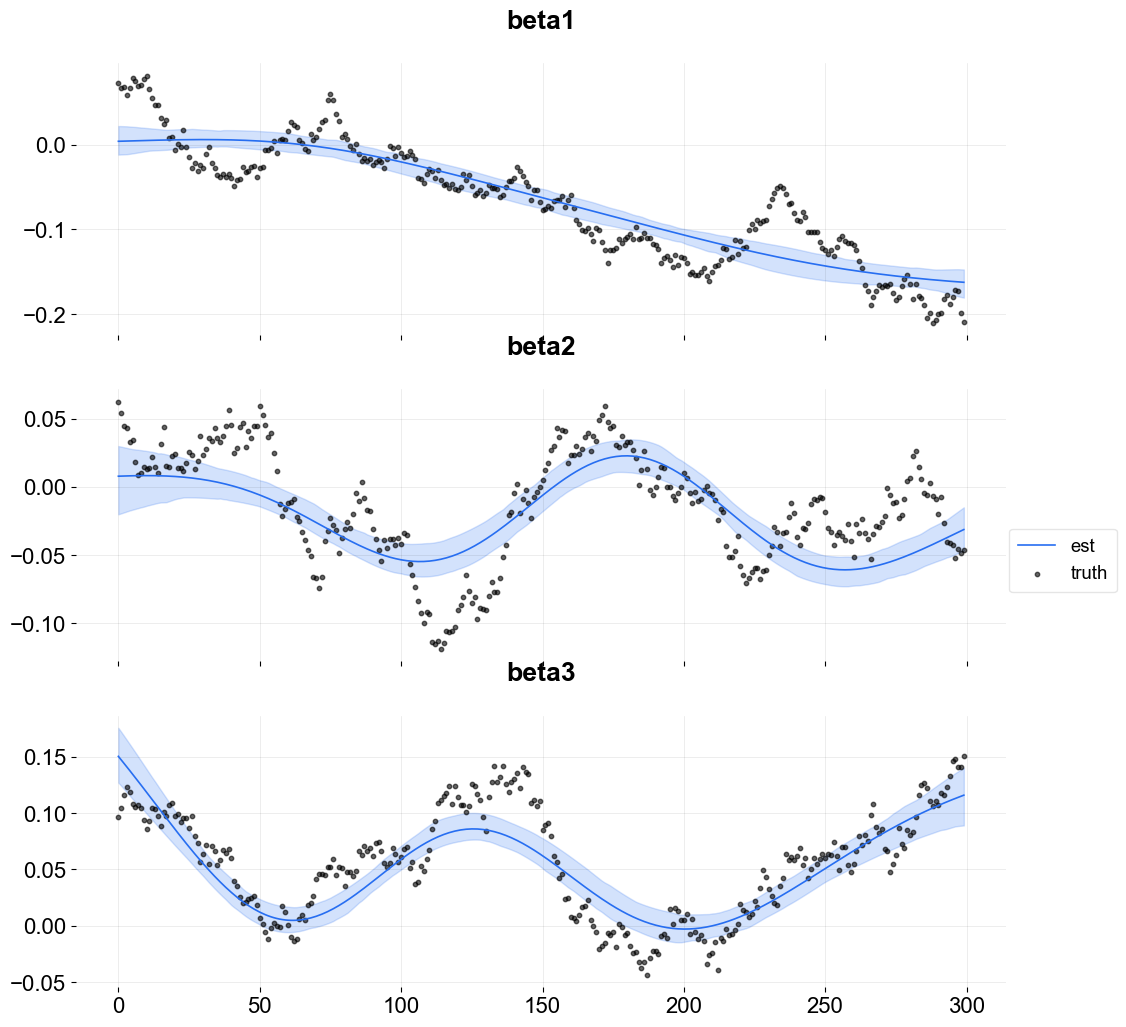

In [12]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", color=OrbitPalette.BLUE.value)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.2, color=OrbitPalette.BLUE.value)
    axes[idx].scatter(x, rw_data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.6, color=OrbitPalette.BLACK.value)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

To plot coefficients use the function `plot_regression_coefs` from the KTR class.

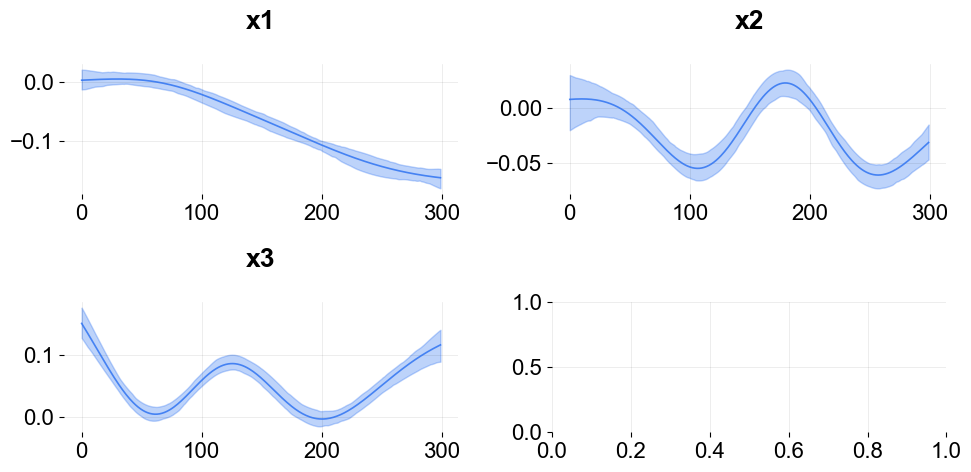

In [13]:
ktr.plot_regression_coefs(figsize=(10, 5), include_ci=True);

These type of time-varying coefficients detection problems are not new. Bayesian approach such as the  R packages Bayesian Structural Time Series (a.k.a **BSTS**) by Scott and Varian (2014) and **tvReg** Isabel Casas and Ruben Fernandez-Casal (2021). Other frequentist approach such as Wu and Chiang (2000).

For further studies on benchmarking coefficients detection, Ng, Wang and Dai (2021) provides a detailed comparison of **KTR** with other popular time-varying coefficients methods; **KTR** demonstrates superior performance in the random walk data simulation. 

## Customizing Priors and Number of Knot Segments

To demonstrate how to specify the number of knots and priors consider the sine-cosine like simulated dataset. In this dataset, the fitting is more tricky since there could be some better way to define the number and position of the knots. There are obvious "change points" within the sine-cosine like curves. In **KTR** there are a few arguments that can leveraged to assign a priori knot attributes:

1. `regressor_init_knot_loc` is used to define the prior mean of the knot value. e.g. in this case, there is not a lot of prior knowledge so zeros are used.
2. The `regressor_init_knot_scale` and `regressor_knot_scale` are used to tune the prior sd of the global mean of the knot and the sd of each knot from the global mean respectively. These create a plausible range for the knot values.
3. The `regression_segments` defines the number of between knot segments (the number of knots - 1). The higher the number of segments the more change points are possible. 


In [14]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),
    regression_segments=6,

    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=sc_data)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 828.02, scale = 0.10882
INFO:orbit:step  100 loss = 340.58, scale = 0.87797
INFO:orbit:step  200 loss = 266.67, scale = 0.37411
INFO:orbit:step  300 loss = 261.21, scale = 0.43775


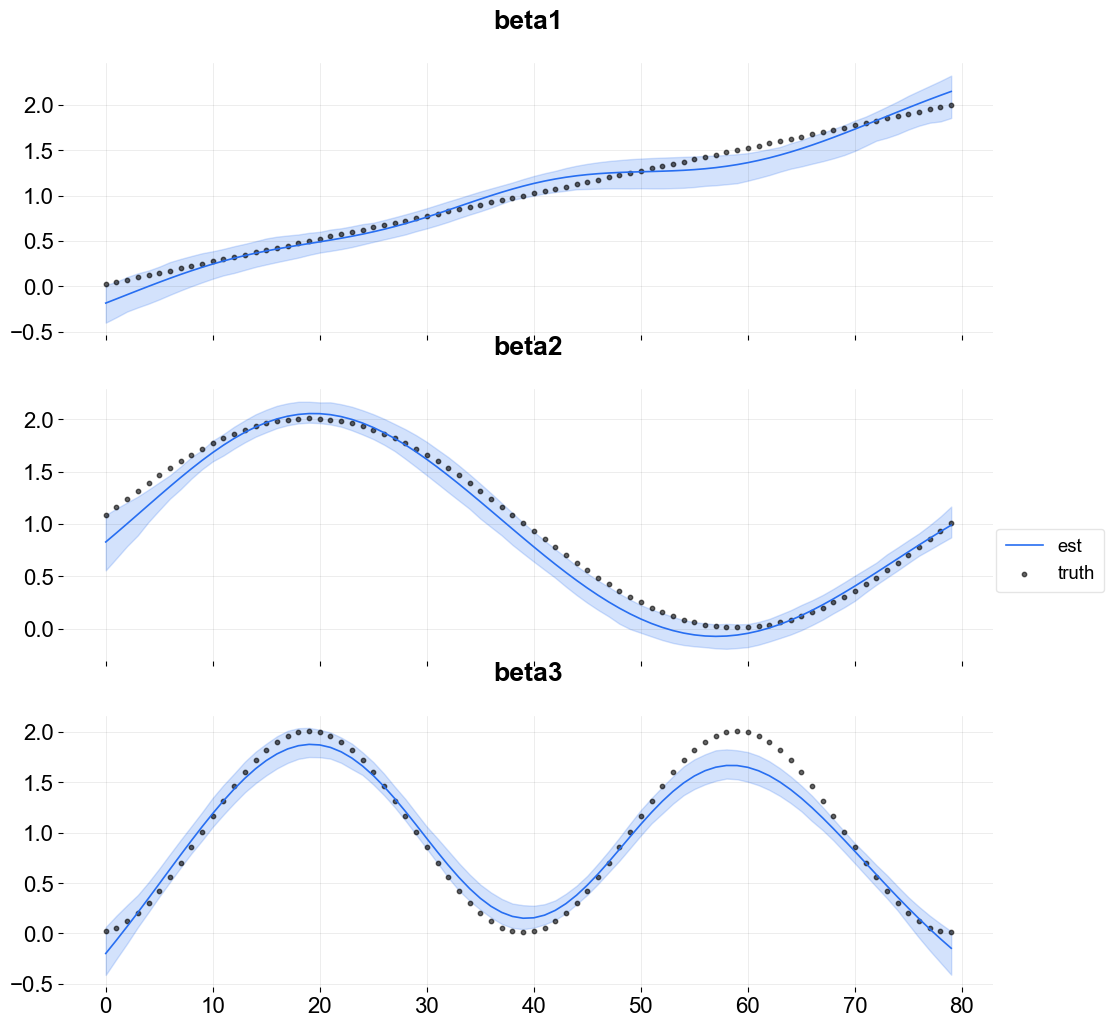

In [15]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", color=OrbitPalette.BLUE.value)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.2, color=OrbitPalette.BLUE.value)
    axes[idx].scatter(x, sc_data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.6, color=OrbitPalette.BLACK.value)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1, 0.5));

Visualize the knots using the `plot_regression_coefs` function with `with_knot=True`.

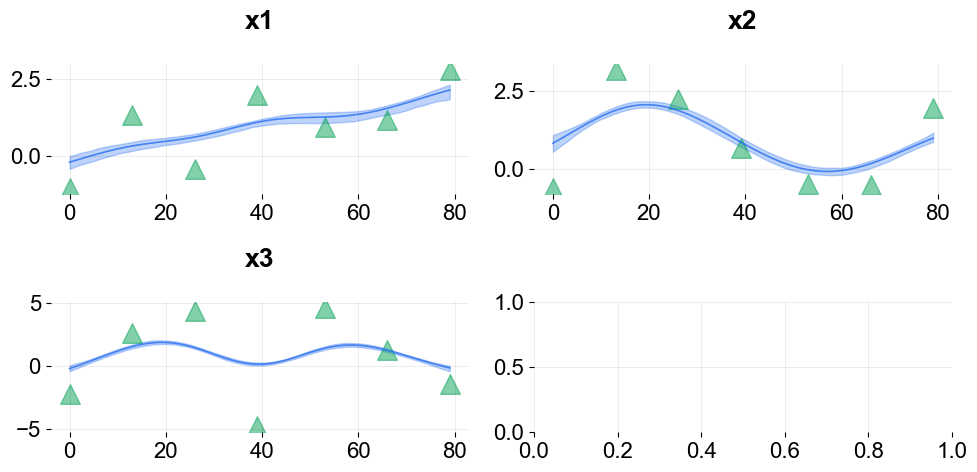

In [16]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=True);

There are more ways to define knots for regression as well as seasonality and trend (a.k.a levels). These are described in **Part III**

## References

1. Ng, Wang and Dai (2021). Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 
2. Isabel Casas and Ruben Fernandez-Casal (2021). tvReg: Time-Varying Coefficients Linear Regression for Single and Multi-Equations. https://CRAN.R-project.org/package=tvReg R package version 0.5.4.
3. Steven L Scott and Hal R Varian (2014). Predicting the present with bayesian structural time series. International Journal of Mathematical Modelling and Numerical Optimisation 5, 1-2 (2014), 4–23.